# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

#### Project by: I Wayan Nadiantara

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## 1. Introduction: Business Problem <a name="introduction"></a>

Budi just accepted to study at ITB (Bandung Institute of Technology), one of the best Indonesian University in the city of Bandung. Let say Budi is not from Bandung, so he needs to get a flat or room in there. He wants a neighbor that is not really far from the campus and also around good cheap restaurants or cafes.

Let say I want to help Budi, I need to find data about restaurants and cafes around the city of Bandung. Bandung is notorious for being an Indonesian culinary destination. There's a lot of restaurants and cafes in the city but I must give him the best possible neighborhood to live based on the data available. Ideally, I should use the Google places API to get better data, but due to the paywall limit regarding that API, my suggestion will be based on a combination of data from the Foursquare API and the Zomato API.

Foursquare City Guide, commonly known as Foursquare, is a local search-and-discovery mobile app developed by Foursquare Labs Inc. The app provides personalized recommendations of places to go near a user's current location based on users' previous browsing history and check-in history. Zomato is a restaurant aggregator and food delivery start-up which provides information, menus, and user-reviews of restaurants as well as food delivery options from partner restaurants in select cities. As of 2019, the service is available in 24 countries and in more than 10,000 cities, including Bandung. So here are the problems:

1. How could I determine which neighborhood is the best for Budi to live in Bandung?
2. Which neighborhood is the best for him?
3. What are the advantages and disadvantages of each neighborhood projected by the data?



## 2. Data <a name="data"></a>

I use Zomato’s(https://developers.zomato.com/api) and Foursquare’s API  (https://foursquare.com/developers/apps)  to retrieve the data that I need and then I combine it.  From Zomato’s API I’ll get data which consist of these properties of a restaurant :
1.	Name:
2.	Address
3.	Rating
4.	Price range
5.	Price for two
6.	Latitude
7.	Longitude

Meanwhile, from Foursquare I will get data such as:
1.	Name:
2.	Category:
3.	Latitude:
4.	Longitude:

From all of those data, I will create clustering metrics and make some clusters with the K-Means algorithm. From each cluster, I’ll retrieve any points that reflect the advantages or disadvantages, visualize it, and then tell Budi as a suggestion. 


__Module and map:__ Here were imported all dependencies that needed also initializing the map that we will use. Point that marked by red baloon at the map below is the Bandung Institut of Technology, meanwhile the blue baloon mark is the city centre. All maps image will not appear at this notebook, consider open "map_picture.pdf" file at this repository if you want to see the map images.

In [74]:
# importing dependencies
# basic module
import requests # handling requests
import pandas as pd # data management
import numpy as np # python array 
import random # random number generator
import json
import geopy

# geopy module
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# visualization module 
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html
import seaborn as sns
    
# data management
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


import folium 
from bs4 import BeautifulSoup

print('Libraries successfully imported.')

Libraries successfully imported.


#### Loading initial map: Attention, this map may not appear if you open this file at Github, consider open "map_picture.pdf"  file in repository if you want to see it. 

In [10]:
# Bandung

#Bandung city centre's coordinates
bandung_lat = -6.9175
bandung_long =  107.6191
# Bandung Institut of Technology's coordinates
itb_lat = -6.8915
itb_long = 107.6107

# Drawing the map
bandung_map = folium.Map(location = [bandung_lat, bandung_long], zoom_start = 13)
folium.Marker([bandung_lat, bandung_long], popup="City Center" ).add_to(bandung_map)
folium.Marker([itb_lat, itb_long], popup= "ITB Bandung Campus", 
              icon=folium.Icon(color='red', icon='info-sign')).add_to(bandung_map)
bandung_map.save("bandung/BandungMap.html")
bandung_map

__Getting the data from Foursquare:__ Here were minned the data that needed using Foursquare API, the first box below contain variables with credentials and general parameters, the second box contain method regarding how to fetch the specific category that we want from the data, and the third box contain retrieving process from Foursquare.

In [16]:
# Credential
CLIENT_ID = 'YKAEK12CL44TAFRIOSXXCVJFZNV13LSABVXZCBQ5FTKEDW4L' # API Foursquare_ID
CLIENT_SECRET = 'MOP0THZS0D4RT3PTN1NZTEI3NZG4GZCHEHQSEST0ZKFQRQAF' # API Foursquare_SECRET
VERSION = '20200210' # version

# radius and limit
radius=7000
LIMIT=200


In [8]:
def get_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [17]:
pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

# I need to fetch all the venues in certain radius, 
# so the loop keep running wiht "While->True" until there is no venue left.

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        bandung_lat, 
                                                                        bandung_long, 
                                                                        radius,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, radius/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 7.0 Km


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 100 venues fetched within a total radius of 7.0 Km
Total 29 venues fetched within a total radius of 7.0 Km

Total 229 venues fetched


__Check and save:__ I need to check the data and clean the empty rows. Also, because I have limited calls using this API, it's always better if the data that I just retrieved is exported to some .csv file, I also named my default index as "index. This will make my index as "PRIMARY KEY" and by this way I could merge this data with Zomato's data.

In [16]:
# foursquare_venues.to_csv(r'bandung\foursquare_venues.csv', index = False)
foursquare_venues = pd.read_csv(r'bandung\foursquare_venues.csv')
foursquare_venues_clean = foursquare_venues.dropna().reset_index(drop=True)
foursquare_venues.index.name = "index"
foursquare_venues

,venue,categories,latitude,longitude
index,,,,
0,KOZI a Coffee Lab.,Coffee Shop,-6.916535,107.620886
1,Crowne Plaza Bandung,Hotel,-6.917110,107.612007
2,Ayam Goreng Nikmat (Panaitan),Fried Chicken Joint,-6.919545,107.617412
3,éL Royale Hotel Bandung,Hotel,-6.916102,107.610600
4,Sushi Tei,Sushi Restaurant,-6.917206,107.613311
...,...,...,...,...
224,Rammona Bakery,Bakery,-6.964787,107.588952
225,Warung Sate Mekar Wangi,BBQ Joint,-6.941521,107.566668
226,RM Soto Sadang Purwakarta,Asian Restaurant,-6.938447,107.670238


__Getting the data from Zomato:__ Here were minned the data that needed using Zomato API, the first box below contain credentials and empty list, and the second box contain loop regarding how to fetch the specific venue based on the Foursquare data.

In [18]:
#Zomato 
headers = {'user-key': '690c32aa99df86aa8520003b0629467e'}
venues_information = []


In [19]:
for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

__Check and save:__ I need to check the data and clean the empty rows. Also, because I have limited calls using this API, it's always better if the data that I just retrieved is exported to some .csv file

In [17]:
# zomato_venues.to_csv(r'bandung\zomato_venues.csv', index = False)

In [18]:
zomato_venues = pd.read_csv(r'bandung\zomato_venues.csv')

__Fix and Clean:__ This data contain "latitude" and "longitude" variables in object type, also empty rows, here I fixed it

In [19]:
zomato_venues_clean = zomato_venues.dropna().reset_index()
zomato_venues_clean.dtypes

index              int64
venue             object
latitude         float64
longitude        float64
price_for_two    float64
price_range      float64
rating           float64
address           object
dtype: object

In [20]:
zomato_venues_clean[["latitude", "longitude"]] = zomato_venues_clean[["latitude", "longitude"]].astype("float")
zomato_venues_clean

,index,venue,latitude,longitude,price_for_two,price_range,rating,address
0,0,Kozi Lab,-6.916558,107.620945,100000.0,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung"
1,1,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,500000.0,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N..."
2,2,Ayam Goreng Nikmat,-6.919658,107.617394,80000.0,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung"
3,3,Furama Restaurant,-6.915615,107.610410,200000.0,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung"
4,4,Sushi Tei,-6.917129,107.613353,250000.0,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung"
...,...,...,...,...,...,...,...,...
205,224,Bandung Kunafe,-6.960057,107.580964,100000.0,2.0,0.0,"Miko Mall, Lantai 1, Food Court, Jl. Raya Kopo..."
206,225,Dapoer Pandan Wangi,-6.928570,107.581890,200000.0,3.0,3.7,"Jl. Terusan Pasir Koja No. 380, Caringin, Bandung"
207,226,RM Andalus,-6.946114,107.666700,100000.0,2.0,0.0,"Jl. Tata Surya No. 46, Rancasari, Bandung"
208,227,Delivery Coffee Black Metal,-6.894956,107.559831,70000.0,1.0,0.0,"Jl. Raya Cimindi No. 190, Cicendo, Bandung"


__Overlay Test:__ In this part folium map were overlayed by every venue that I get from (i) Foursquare and (ii) Zomato with Foursquare parameters. The first box is an overlay with Foursquare venues, and the second one is with Zomato venues.

In [24]:
# Overlaying with Foursquare venues data.

bandung_foursquare_venues = folium.Map(location = [bandung_lat, bandung_long], zoom_start = 13)
folium.Marker([bandung_lat, bandung_long], popup="City Center" ).add_to(bandung_foursquare_venues)
folium.Marker([itb_lat, itb_long], popup= "ITB Bandung Campus", 
              icon=folium.Icon(color='red', icon='info-sign')).add_to(bandung_foursquare_venues)

for name, latitude, longitude in zip(foursquare_venues['venue'], foursquare_venues['latitude'], foursquare_venues['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(bandung_foursquare_venues)  

bandung_foursquare_venues.save("bandung/bandung_foursquare_venues1.html")
bandung_foursquare_venues

In [25]:
# Overlaying with Zomato venues data.

zomato_map = folium.Map(location = [bandung_lat, bandung_long], zoom_start = 13)
folium.Marker([bandung_lat, bandung_long], popup="City Center" ).add_to(zomato_map)
folium.Marker([itb_lat, itb_long], popup= "ITB Bandung Campus", 
              icon=folium.Icon(color='red', icon='info-sign')).add_to(zomato_map)

for venue, address, latitude, longitude in zip(zomato_venues_clean['venue'], zomato_venues_clean['address'], 
                                               zomato_venues_clean['latitude'], zomato_venues_clean['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(zomato_map)  

bandung_map.save("bandung/zomato_map.html")
zomato_map


## 3. Methodology <a name="methodology"></a>



In this project, the data that I retrieved from Foursquare and Zomato will be merged. The data from Zomato's API is retrieved using Foursquare's parameters, this will make some rows or values is missing in Zomato Data. We already clean it at "Data" section. The data that already cleaned will be merged with the data from Foursquare API. I will drop all data from Foursquare API that have no match with its Zomato counterparts. 

I use the "index" as Primary Key from Foursquare and Zomato, so the data will be merged based on this index. After the merger, I'll clean some columns and rows that is not relevant for the analysis. When data cleaning is done, I will visualize it to gain initial insight or expectation from the data.

After initial visualization, I will make a table with relevant columns as metrics for K-Means clustering. I'll tree some values of K, analyze the result of each value, visualize it, and make conclusions for solving the problem.

## 4. Analysis <a name="analysis"></a>

__Merging and cleaning:__ Two boxes of code below contain merging and then cleaning process. In the first box, I'll change the some columns name from each data; Foursquare and Zomato, after that I'll merge it and then I'll drop some columns that no longer relevant for analysis. 

In [26]:
# Renaming some columns
zomato_venues_clean = zomato_venues_clean.rename(columns={"lat": "latitude", "lng": "longitude"})
foursquare_venues_fix = foursquare_venues.rename(columns={"name":"venue", "lat": "latitude", 
                                                                "lng": "longitude"})
# Merging Foursquare and Zomato data
bandung_venues_merge = pd.merge(foursquare_venues_fix,zomato_venues_clean, on=['index'])
bandung_venues_merge

,index,venue_x,categories,latitude_x,longitude_x,venue_y,latitude_y,longitude_y,price_for_two,price_range,rating,address
0,0,KOZI a Coffee Lab.,Coffee Shop,-6.916535,107.620886,Kozi Lab,-6.916558,107.620945,100000.0,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung"
1,1,Crowne Plaza Bandung,Hotel,-6.917110,107.612007,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,500000.0,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N..."
2,2,Ayam Goreng Nikmat (Panaitan),Fried Chicken Joint,-6.919545,107.617412,Ayam Goreng Nikmat,-6.919658,107.617394,80000.0,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung"
3,3,éL Royale Hotel Bandung,Hotel,-6.916102,107.610600,Furama Restaurant,-6.915615,107.610410,200000.0,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung"
4,4,Sushi Tei,Sushi Restaurant,-6.917206,107.613311,Sushi Tei,-6.917129,107.613353,250000.0,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung"
...,...,...,...,...,...,...,...,...,...,...,...,...
205,224,Rammona Bakery,Bakery,-6.964787,107.588952,Bandung Kunafe,-6.960057,107.580964,100000.0,2.0,0.0,"Miko Mall, Lantai 1, Food Court, Jl. Raya Kopo..."
206,225,Warung Sate Mekar Wangi,BBQ Joint,-6.941521,107.566668,Dapoer Pandan Wangi,-6.928570,107.581890,200000.0,3.0,3.7,"Jl. Terusan Pasir Koja No. 380, Caringin, Bandung"
207,226,RM Soto Sadang Purwakarta,Asian Restaurant,-6.938447,107.670238,RM Andalus,-6.946114,107.666700,100000.0,2.0,0.0,"Jl. Tata Surya No. 46, Rancasari, Bandung"
208,227,Stasiun Cimindi,Train Station,-6.896124,107.561040,Delivery Coffee Black Metal,-6.894956,107.559831,70000.0,1.0,0.0,"Jl. Raya Cimindi No. 190, Cicendo, Bandung"


In [27]:
# Dropping some irrelevant columns
bandung_venues_merge_fix = bandung_venues_merge.drop(columns=["venue_x","latitude_x", "longitude_x"])
bandung_venues_merge_fix

,index,categories,venue_y,latitude_y,longitude_y,price_for_two,price_range,rating,address
0,0,Coffee Shop,Kozi Lab,-6.916558,107.620945,100000.0,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung"
1,1,Hotel,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,500000.0,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N..."
2,2,Fried Chicken Joint,Ayam Goreng Nikmat,-6.919658,107.617394,80000.0,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung"
3,3,Hotel,Furama Restaurant,-6.915615,107.610410,200000.0,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung"
4,4,Sushi Restaurant,Sushi Tei,-6.917129,107.613353,250000.0,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung"
...,...,...,...,...,...,...,...,...,...
205,224,Bakery,Bandung Kunafe,-6.960057,107.580964,100000.0,2.0,0.0,"Miko Mall, Lantai 1, Food Court, Jl. Raya Kopo..."
206,225,BBQ Joint,Dapoer Pandan Wangi,-6.928570,107.581890,200000.0,3.0,3.7,"Jl. Terusan Pasir Koja No. 380, Caringin, Bandung"
207,226,Asian Restaurant,RM Andalus,-6.946114,107.666700,100000.0,2.0,0.0,"Jl. Tata Surya No. 46, Rancasari, Bandung"
208,227,Train Station,Delivery Coffee Black Metal,-6.894956,107.559831,70000.0,1.0,0.0,"Jl. Raya Cimindi No. 190, Cicendo, Bandung"


__New parameter:__ From the introduction, I already explained that the distance from the University's campus will be matter for the solution. Here, I will use geopy.distance module to computing the distance when latitude and longitude of the points are known.

In [35]:
# Defining method to compute distance each venue from Bandung Institut of Technology
from geopy import distance
def distance_from_ITB (latitudex, longitudex):
    itb_coordinates = (itb_lat, itb_long)
    place_xy = (latitudex, longitudex)
    distance_ = geopy.distance.distance(itb_coordinates, place_xy).km
    return distance_


In [37]:
center_distance=[]
for latitude, longitude in zip (bandung_venues_merge_fix["latitude_y"], bandung_venues_merge_fix["longitude_y"]):
    distance_venue = distance_from_ITB(latitude, longitude)
    center_distance.append(distance_venue)
     
distance_df = pd.DataFrame(center_distance, columns =['distance_from_ITB']) 
distance_df 

,distance_from_ITB
0,2.993580
1,2.838805
2,3.200650
3,2.667078
4,2.849432
...,...
205,8.263294
206,5.190788
207,8.647543
208,5.635026


In [61]:
# concating the distance values dataframe to the merged data
new_venue = pd.concat([bandung_venues_merge_fix, distance_df], axis = 1)


__More cleaning and fixing:__ After the distances data were merged we need to clean some columns again, and recount the average price. The average price that given by Zomato's API is average for two persons. We need to divide each value of that column with 2. Also I checked that the "rating" columns contain object type data, I need to change it to float type data. 

In [62]:
new_venue = new_venue.rename(columns={"venue_y":"venue","latitude_y": "latitude",
                                      "longitude_y": "longitude", "price_for_two":"average_price"})
new_venue["average_price"]=new_venue["average_price"]/2

In [63]:
new_venue[["rating"]]=new_venue[["rating"]].astype("float")

In [64]:
new_venue

,index,categories,venue,latitude,longitude,average_price,price_range,rating,address,distance_from_ITB
0,0,Coffee Shop,Kozi Lab,-6.916558,107.620945,50000.0,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung",2.993580
1,1,Hotel,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,250000.0,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N...",2.838805
2,2,Fried Chicken Joint,Ayam Goreng Nikmat,-6.919658,107.617394,40000.0,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung",3.200650
3,3,Hotel,Furama Restaurant,-6.915615,107.610410,100000.0,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung",2.667078
4,4,Sushi Restaurant,Sushi Tei,-6.917129,107.613353,125000.0,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung",2.849432
...,...,...,...,...,...,...,...,...,...,...
205,224,Bakery,Bandung Kunafe,-6.960057,107.580964,50000.0,2.0,0.0,"Miko Mall, Lantai 1, Food Court, Jl. Raya Kopo...",8.263294
206,225,BBQ Joint,Dapoer Pandan Wangi,-6.928570,107.581890,100000.0,3.0,3.7,"Jl. Terusan Pasir Koja No. 380, Caringin, Bandung",5.190788
207,226,Asian Restaurant,RM Andalus,-6.946114,107.666700,50000.0,2.0,0.0,"Jl. Tata Surya No. 46, Rancasari, Bandung",8.647543
208,227,Train Station,Delivery Coffee Black Metal,-6.894956,107.559831,35000.0,1.0,0.0,"Jl. Raya Cimindi No. 190, Cicendo, Bandung",5.635026


__Initial visualization:__ In this part I will do basic visualization like binning and scatter plot to gain initial insight or expectation from the data. First I'll make bins that consist of three values (nearby, not far, and qiet far) from the "distance_from_ITB columns", second I will make bins from the "average_price" that consist of four values (low, medium-low, medium-high, high). The last visualization from this section is scatter 3D plot with distance, average price, and rating as the axis.

In [65]:
# Binning distance
bins_distance = np.linspace(min(new_venue["distance_from_ITB"]), max(new_venue["distance_from_ITB"]), 4)
distance_group = ["nearby","not far","quiet far"]
new_venue["bins_distance"] = pd.cut(new_venue["distance_from_ITB"], bins_distance, labels = distance_group, include_lowest=True)


# Binning average price
bins_price = np.linspace(min(new_venue["average_price"]), max(new_venue["average_price"]), 5)
price_group = ["low","low-medium","medium-high","high"]
new_venue["bins_price"] = pd.cut(new_venue["average_price"], bins_price, labels = price_group, include_lowest=True)



In [67]:
print(new_venue["bins_distance"].value_counts())
print(new_venue["bins_price"].value_counts())

nearby       98
not far      88
quiet far    24
Name: bins_distance, dtype: int64
low            156
low-medium      49
medium-high      4
high             1
Name: bins_price, dtype: int64


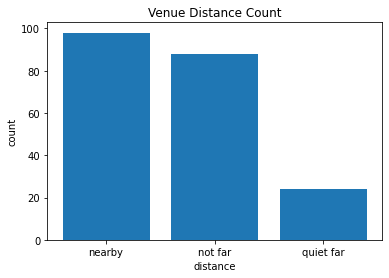

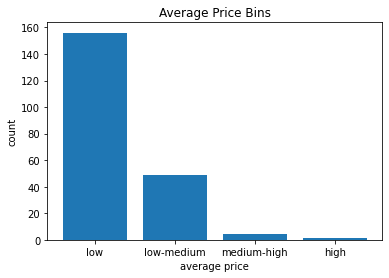

In [68]:
# Make bar graph form the bins

%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

pyplot.bar(distance_group, new_venue["bins_distance"].value_counts())
plt.pyplot.xlabel("distance")
plt.pyplot.ylabel("count")
plt.pyplot.title("Venue Distance Count")
plt.pyplot.show()

pyplot.bar(price_group, new_venue["bins_price"].value_counts())
plt.pyplot.xlabel("average price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Average Price Bins")
plt.pyplot.show()


__What should I expect from these visualizations?:__ From the bins bar graph above and 3D scatterplot below, I expect that it should be easy for Budi to get the right neighborhood that he want. First distance bins give me indication that a lot of venues are nearby the campus. The average price bins give me indication that most venues are at "low" average price bins. The 3D scatter plot below give me an insight, that there are relatively a lot of venues nearby the campus, which has "low" average prices and quite high ratings.

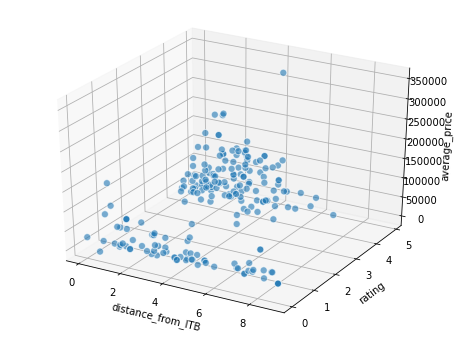

In [69]:
# 3D scatter plot

fig = plt.pyplot.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = new_venue['distance_from_ITB']
ys = new_venue['rating']
zs = new_venue['average_price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('distance_from_ITB')
ax.set_ylabel('rating')
ax.set_zlabel('average_price')
plt.pyplot.show()

__Clustering with K-Means algorithm:__ In this part I will use K-Means algorithm to divide all venues to some clusters based on their numerical properties. First thing I need from this section is to normalize the "average_price" column. As you know, the average price data that given by Zomato API is in Indonesian currency (IDR) which has relatively big values if we compared it to other parameters of the data or also other currency (1 USD = 15.000 IDR), so we have to normalize these values or else these value will dominate the clustering metrics. 

After that I will also drop some columns that is not relevant to this clustering algorithm such as 'venue', 'address', 'bins_distance','bins_price','categories', and 'index'.

In [70]:
# normalization of price
new_venue["average_price"]=new_venue["average_price"]/new_venue["average_price"].max()

new_venue

,index,categories,venue,latitude,longitude,average_price,price_range,rating,address,distance_from_ITB,bins_distance,bins_price
0,0,Coffee Shop,Kozi Lab,-6.916558,107.620945,0.142857,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung",2.993580,nearby,low
1,1,Hotel,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,0.714286,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N...",2.838805,nearby,medium-high
2,2,Fried Chicken Joint,Ayam Goreng Nikmat,-6.919658,107.617394,0.114286,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung",3.200650,not far,low
3,3,Hotel,Furama Restaurant,-6.915615,107.610410,0.285714,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung",2.667078,nearby,low-medium
4,4,Sushi Restaurant,Sushi Tei,-6.917129,107.613353,0.357143,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung",2.849432,nearby,low-medium
...,...,...,...,...,...,...,...,...,...,...,...,...
205,224,Bakery,Bandung Kunafe,-6.960057,107.580964,0.142857,2.0,0.0,"Miko Mall, Lantai 1, Food Court, Jl. Raya Kopo...",8.263294,quiet far,low
206,225,BBQ Joint,Dapoer Pandan Wangi,-6.928570,107.581890,0.285714,3.0,3.7,"Jl. Terusan Pasir Koja No. 380, Caringin, Bandung",5.190788,not far,low-medium
207,226,Asian Restaurant,RM Andalus,-6.946114,107.666700,0.142857,2.0,0.0,"Jl. Tata Surya No. 46, Rancasari, Bandung",8.647543,quiet far,low
208,227,Train Station,Delivery Coffee Black Metal,-6.894956,107.559831,0.100000,1.0,0.0,"Jl. Raya Cimindi No. 190, Cicendo, Bandung",5.635026,not far,low


In [76]:
# Clustering with 4 cluster

Knumbers = 4

# dropping some columns
df_clusters = new_venue.drop(['venue', 'address', 'bins_distance','bins_price','categories','index',], 1)



In [72]:
# Clustering using Kmeans algorithm from sklearn
kMeans = KMeans(n_clusters = Knumbers, random_state = 0).fit(df_clusters)
new_venue.insert(0, 'cluster_labels', kMeans.labels_)


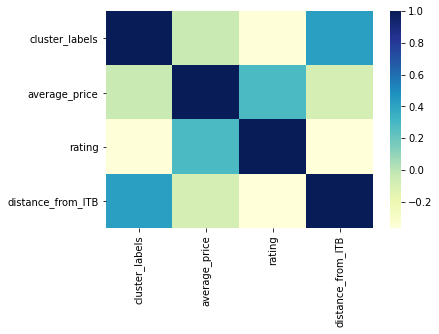

In [77]:
# Using heatmap to see any linear correlation of the parameters
df_clusters = df_clusters.drop(["latitude","longitude","price_range"],1)
df_clusters.corr()
ax1 = sns.heatmap(df_clusters.corr(),  cmap="YlGnBu")

In [84]:
# count the member of each clusters
new_venue["cluster_labels"].value_counts()


0    97
2    49
3    39
1    25
Name: cluster_labels, dtype: int64

__Visualization of clusters__ Here I will visualize each cluster by overlaying it on folium map.  All Venues that are member of Cluster 0 depicted by "dark pink" points scattered on the map. All Venues that are member of Cluster 1 depicted by "red" points scattered on the map. All Venues that are member of Cluster 2 depicted by "light green" points scattered on the map. All Venues that are member of Cluster 3 depicted by "light blue" points scattered on the map.

In [94]:
# neighbor clustered in a map 
venues_map_clusters = folium.Map(location = [bandung_lat, bandung_long], zoom_start = 13)
folium.Marker([bandung_lat, bandung_long], popup="City Center" ).add_to(venues_map_clusters)
folium.Marker([itb_lat, itb_long], popup= "ITB Bandung Campus", 
              icon=folium.Icon(color='red', icon='info-sign')).add_to(venues_map_clusters)

# set color 
x = np.arange(Knumbers)
ys = [i + x + (i*x)**2 for i in range(Knumbers)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
gist_rainbow = [colors.rgb2hex(i) for i in colors_array]

# set markers for each cluster
markers_colors = []
for lat, lon, poi, cluster in zip(new_venue['latitude'], new_venue['longitude'],
                                  new_venue['venue'], new_venue['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=gist_rainbow[cluster-1],
        fill=True,
        fill_color=gist_rainbow[cluster-1],
        fill_opacity=0.8).add_to(venues_map_clusters)
       
venues_map_clusters

__Cluster 0 members:__ Here are the member of cluster 0, this is the cluster with the most venues. There are 97 members of this cluster. On the map, these venues depicted by "dark pink" points.

In [123]:
# cluster 0 members
new_venue.loc[new_venue['cluster_labels'] == 0, 
              new_venue.columns[[1] + list(range(1, new_venue.shape[1]))]].reset_index(drop=True)

,index,index,categories,venue,latitude,longitude,average_price,price_range,rating,address,distance_from_ITB,bins_distance,bins_price
0,0,0,Coffee Shop,Kozi Lab,-6.916558,107.620945,0.142857,2.0,3.9,"Jl. Gudang Selatan No. 22, Sumurbandung, Bandung",2.993580,nearby,low
1,1,1,Hotel,Infinite Cafe & Lounge - Crowne Plaza Bandung,-6.917136,107.612013,0.714286,4.0,3.4,"Crowne Plaza Bandung, Lantai 22, Jl. Lembong N...",2.838805,nearby,medium-high
2,2,2,Fried Chicken Joint,Ayam Goreng Nikmat,-6.919658,107.617394,0.114286,2.0,3.9,"Jl. Panaitan No. 9, Sumurbandung, Bandung",3.200650,not far,low
3,4,4,Sushi Restaurant,Sushi Tei,-6.917129,107.613353,0.357143,3.0,4.4,"Jl. Sumatera No. 9, Sumurbandung, Bandung",2.849432,nearby,low-medium
4,5,5,Bakery,Rasa Bakery & Cafe,-6.919331,107.612562,0.214286,3.0,4.4,"Jl. Tamblong No. 15, Sumurbandung, Bandung",3.084736,not far,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,198,198,BBQ Joint,The Volcano Resto,-6.881086,107.582616,0.357143,3.0,4.1,"Setrasari Plaza, Blok B3, Jl. Terusan Prof Dr....",3.310667,not far,low-medium
93,199,199,Breakfast Spot,Kopi Tiam Hochiak,-6.881274,107.582181,0.171429,2.0,3.4,"Komplek Setrasari Mall, Blok B3, Jl. Surya Sum...",3.348733,not far,low
94,201,201,Bakery,Kue Westhoff,-6.881168,107.582106,0.142857,2.0,3.5,"Setrasari Plaza, Blok B9, Jl. Surya Sumantri, ...",3.360487,not far,low
95,202,202,American Restaurant,Maxi's Resto,-6.867816,107.607675,0.357143,3.0,4.3,"Jl. Gunung Agung No. 8, Ciumbuleuit, Bandung",2.640506,nearby,low-medium


__Cluster 1 members:__ Here are the member of cluster 1, this is the cluster with the least venues. There are 24 members of this cluster. On the map, these venues depicted by "red" points.

In [124]:
# cluster 1 members
new_venue.loc[new_venue['cluster_labels'] == 1, new_venue.columns[[1] + list(range(5, new_venue.shape[1]))]].reset_index(drop=True)

,index,longitude,average_price,price_range,rating,address,distance_from_ITB,bins_distance,bins_price
0,114,107.617719,0.071429,1.0,0.0,"Jl. BKR No. 57, Pungkur, Bandung",5.262680,not far,low
1,124,107.626014,0.114286,2.0,0.0,"Jl. Buah Batu No. 165, Buahbatu, Bandung",5.590572,not far,low
2,140,107.631252,0.142857,2.0,0.0,"Jl. Marta Negara No. 50, Buahbatu, Bandung",5.238954,not far,low
3,147,107.626320,0.285714,3.0,0.0,"Batununggal Indah Club, Jl. Batununggal Indah ...",8.104249,quiet far,low-medium
4,150,107.622662,0.114286,2.0,0.0,"Jl Angkik No 2, Buahbatu, Bandung",5.572872,not far,low
5,166,107.627603,0.114286,2.0,0.0,"Food Life, Jl. Batununggal Raya No. 1, Bandung...",7.046371,quiet far,low
6,173,107.608336,0.428571,3.0,0.0,"Jl. Mekar Utama No. 93 A, Cibaduyut, Bandung",7.047727,quiet far,low-medium
7,179,107.628075,0.085714,1.0,0.0,"Jl. Buah Batu No. 212, Buahbatu, Bandung",6.020240,quiet far,low
8,189,107.638795,0.071429,1.0,0.0,"Transmart Buah Batu, Lantai Ground, Jl. Bojong...",8.908995,quiet far,low
9,193,107.638795,0.071429,1.0,0.0,"Transmart Buah Batu, Lantai Ground, Jl. Bojong...",8.908995,quiet far,low


__Cluster 2 members:__ Here are the member of cluster 2. There are 49 members of this cluster. On the map, these venues depicted by "light green" points.

In [125]:
# cluster 2 members
new_venue.loc[new_venue['cluster_labels'] == 2, new_venue.columns[[1] + list(range(5, new_venue.shape[1]))]].reset_index(drop=True)

,index,longitude,average_price,price_range,rating,address,distance_from_ITB,bins_distance,bins_price
0,3,107.610410,0.285714,3.0,0.0,"Jl. Merdeka No. 2, Braga, Bandung",2.667078,nearby,low-medium
1,8,107.611776,0.214286,3.0,0.0,"Aryaduta Hotel, Jl. Sumatera No. 51, Riau, Ban...",1.971875,nearby,low
2,9,107.615797,0.071429,1.0,0.0,"Jl. Bahureksa No. 35, Riau, Bandung",1.596742,nearby,low
3,10,107.632538,0.114286,2.0,0.0,"Jl. Sukabumi No. 3, Batununggal, Bandung",3.810365,not far,low
4,12,107.609932,0.285714,3.0,0.0,"Best Western Premier La Grande Hotel, Lantai 3...",1.967021,nearby,low-medium
5,14,107.610089,0.214286,3.0,0.0,"Jl. Braga No. 15, Braga, Bandung",3.163538,not far,low
6,18,107.604741,0.214286,3.0,0.0,"Jl. Cihampelas No. 22, Bandung Wetan, Bandung",1.659036,nearby,low
7,21,107.608743,0.071429,1.0,0.0,"Food Court Asia Afrika 90, Jl. Asia Afrika No....",3.363681,not far,low
8,27,107.608964,0.085714,1.0,0.0,"Istana BEC, Lantai 3, Food Court, Jl. Purnawar...",1.904560,nearby,low
9,28,107.607760,0.071429,1.0,0.0,"Jl. Terusan ABC No. 103, Braga, Bandung",3.109717,not far,low


__Cluster 3 members:__ Here are the member of cluster 2. There are 39 members of this cluster. On the map, these venues depicted by "light blue" points.

In [126]:
# cluster 3 members
new_venue.loc[new_venue['cluster_labels'] == 3, new_venue.columns[[1] + list(range(5, new_venue.shape[1]))]].reset_index(drop=True)

,index,longitude,average_price,price_range,rating,address,distance_from_ITB,bins_distance,bins_price
0,7,107.611601,0.357143,3.0,3.4,"Hotel Mercure City Center, Jl. Lengkong Besar ...",3.583881,not far,low-medium
1,24,107.624114,0.285714,3.0,4.5,"Jl Patuha No. 38, Lengkong, Bandung",4.348419,not far,low-medium
2,41,107.613392,0.357143,3.0,3.9,"Jl. Lengkong Besar No. 97, Lengkong, Bandung",3.903250,not far,low-medium
3,50,107.636040,1.000000,4.0,4.2,"The Trans Luxury Hotel, Jl. Gatot Subroto No. ...",4.835407,not far,high
4,54,107.627480,0.314286,3.0,3.7,"Jl. Pelajar Pejuang 45 No. 21, Buahbatu, Bandung",4.312434,not far,low-medium
5,63,107.636527,0.171429,2.0,2.8,"Trans Studio Mall, Lantai 2, Jl. Jendral Gatot...",4.817160,not far,low
6,64,107.624940,0.228571,3.0,2.9,"Jl. Buah Batu No. 159, Buahbatu, Bandung",5.468988,not far,low
7,68,107.635884,0.357143,3.0,4.3,"Trans Studio Mall, Lantai Ground, Jl. Jendral ...",4.764379,not far,low-medium
8,79,107.625598,0.214286,3.0,3.7,"Jl. Buah Batu No. 165A, Buahbatu, Bandung",5.579573,not far,low
9,82,107.644334,0.142857,2.0,3.4,"Jl. Terusan Jakarta No. 77E, Kiaracondong, Ban...",4.470933,not far,low


__Dataframe of clusters:__ Put each cluster data to its own dataframe and count its average price, distance, and rating

In [128]:
# Dataframe for cluster 0
df_cluster_0 = new_venue.loc[new_venue['cluster_labels'] == 0, 
              new_venue.columns[[1] + list(range(1, new_venue.shape[1]))]].reset_index(drop=True)

In [129]:
# Dataframe for cluster 1
df_cluster_1 = new_venue.loc[new_venue['cluster_labels'] == 1, 
              new_venue.columns[[1] + list(range(1, new_venue.shape[1]))]].reset_index(drop=True)

In [133]:
# Dataframe for cluster 2
df_cluster_2 = new_venue.loc[new_venue['cluster_labels'] == 2, 
              new_venue.columns[[1] + list(range(1, new_venue.shape[1]))]].reset_index(drop=True)


In [134]:
# Dataframe for cluster 3
df_cluster_3 = new_venue.loc[new_venue['cluster_labels'] == 1, 
              new_venue.columns[[1] + list(range(1, new_venue.shape[1]))]].reset_index(drop=True)


### Clusters analysis

__Cluster 0:__ Cluster 0 has the most number of venues. With scatter plots below we can see that there are relatively many venues nearby ITB, has cheap price, and also relatively high rating. We can see below that the average price of this cluster is  0.21988217967599394, the average distance from this cluster to ITB is 2.1739968384193977 km, and the average rating of this cluster is  3.8567010309278342.

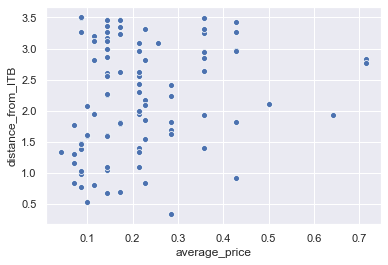

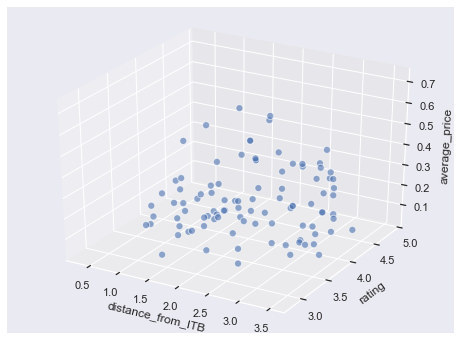

Average price of this cluster:  0.21988217967599394
Average distance of this cluster to ITB:  2.1739968384193977
Average rating of this cluster:  3.8567010309278342


In [127]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="average_price", y="distance_from_ITB", data=df_cluster_0)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = df_cluster_0['distance_from_ITB']
ys = df_cluster_0['rating']
zs = df_cluster_0['average_price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('distance_from_ITB')
ax.set_ylabel('rating')
ax.set_zlabel('average_price')
plt.show()

# printing the average price, rating, and distance
print("Average price of this cluster: ", df_cluster_0["average_price"].mean())
print("Average distance of this cluster to ITB: ", df_cluster_0["distance_from_ITB"].mean())
print("Average rating of this cluster: ", df_cluster_0["rating"].mean())

__Cluster 1:__  Cluster 1 has the least number of venues. With scatter plots below we can see that there are relatively low venues that is nearby ITB. We can see below that the average price of this cluster is 0.13714285714285715, the average distance from this cluster to ITB is 7.349461257651611 km, and the average rating of this cluster is 0.0. I personaly do not find that 0.0 rating is an indication that all venues of this cluster are bad, merely it caused by incomplete data that gave by the user and affect the K-Means algorithm metrics. We can use 0.0 rating as an indication that this cluster not quite popular enough to get any review. From price and distance persepective, this cluster has lower average price from cluster 0 also not realy further away from it.

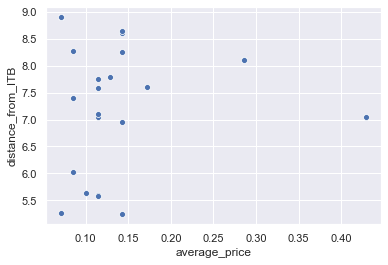

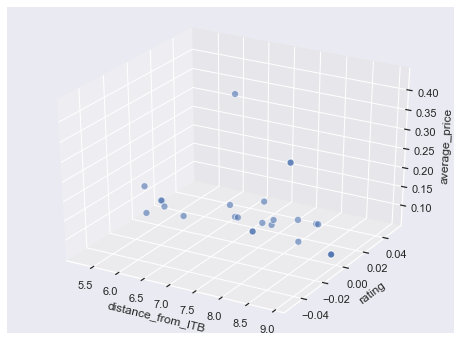

Average price of this cluster:  0.13714285714285715
Average distance of this cluster to ITB:  7.349461257651611
Average rating of this cluster:  0.0


In [130]:

ax = sns.scatterplot(x="average_price", y="distance_from_ITB", data=df_cluster_1)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = df_cluster_1['distance_from_ITB']
ys = df_cluster_1['rating']
zs = df_cluster_1['average_price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('distance_from_ITB')
ax.set_ylabel('rating')
ax.set_zlabel('average_price')
plt.show()

# printing the average price, rating, and distance
print("Average price of this cluster: ", df_cluster_1["average_price"].mean())
print("Average distance of this cluster to ITB: ", df_cluster_1["distance_from_ITB"].mean())
print("Average rating of this cluster: ", df_cluster_1["rating"].mean())

__Cluster 2:__ Cluster 2 has medium number of venues. With scatter plots below we can see that there are relatively low venues that is nearby ITB. We can see below that the average price of this cluster is 0.15743440233236144, the average distance from this cluster to ITB is  2.962959553613458 km, and the average rating of this cluster is 0.0.  I personaly do not find that 0.0 rating is an indication that all venues of this cluster are bad, merely it caused by incomplete data that gave by the user and affect the K-Means algorithm metrics. We can use 0.0 rating as an indication that this cluster not quite popular enough to get any review. From price and distance persepective, this cluster has lower average price from cluster 0 also not realy further away from it.

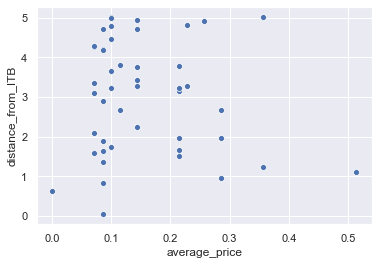

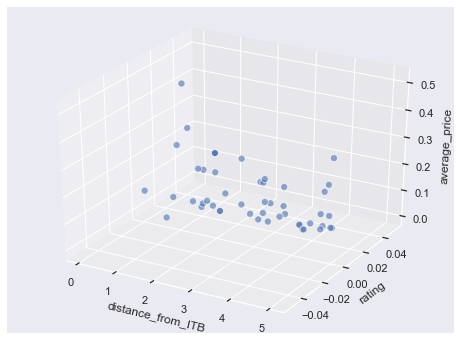

Average price of this cluster:  0.15743440233236144
Average distance of this cluster to ITB:  2.962959553613458
Average rating of this cluster:  0.0


In [140]:
ax = sns.scatterplot(x="average_price", y="distance_from_ITB", data=df_cluster_2)

#3d
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = df_cluster_2['distance_from_ITB']
ys = df_cluster_2['rating']
zs = df_cluster_2['average_price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('distance_from_ITB')
ax.set_ylabel('rating')
ax.set_zlabel('average_price')
plt.show()
# printing the average price, rating, and distance
print("Average price of this cluster: ", df_cluster_2["average_price"].mean())
print("Average distance of this cluster to ITB: ", df_cluster_2["distance_from_ITB"].mean())
print("Average rating of this cluster: ", df_cluster_2["rating"].mean())

__Cluster 3:__ Cluster 3 has quite low number of venues. With scatter plots below we can see that there are relatively low venues that is nearby ITB. We can see below that the average price of this cluster is 0.13714285714285715, the average distance from this cluster to ITB is 7.349461257651611 km, and the average rating of this cluster is 0.0. I personaly do not find that 0.0 rating is an indication that all venues of this cluster are bad, merely it caused by incomplete data that gave by the user and affect the K-Means algorithm metrics. We can use 0.0 rating as an indication that this cluster not quite popular enough to get any review. From price and distance persepective, this cluster has lower average price from cluster 0 also not realy further away from it.

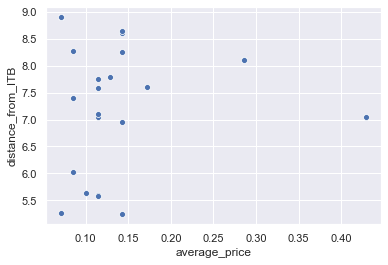

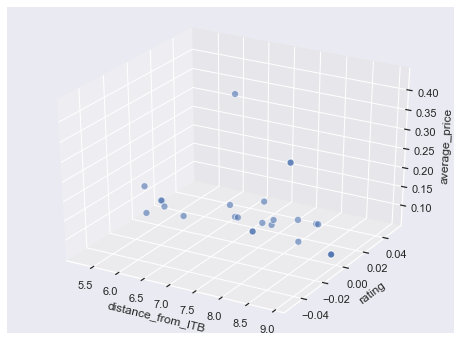

Average price of this cluster:  0.13714285714285715
Average distance of this cluster to ITB:  7.349461257651611
Average rating of this cluster:  0.0


In [131]:
ax = sns.scatterplot(x="average_price", y="distance_from_ITB", data=df_cluster_3)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = df_cluster_3['distance_from_ITB']
ys = df_cluster_3['rating']
zs = df_cluster_3['average_price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('distance_from_ITB')
ax.set_ylabel('rating')
ax.set_zlabel('average_price')
plt.show()
# printing the average price, rating, and distance
print("Average price of this cluster: ", df_cluster_3["average_price"].mean())
print("Average distance of this cluster to ITB: ", df_cluster_3["distance_from_ITB"].mean())
print("Average rating of this cluster: ", df_cluster_3["rating"].mean())

__All cluster review:__ Here I made a plot about corelation of all clusters with the distance and average price. As we can see, cluster 0 and 2 might have the best possible outcome, and cluster 1 and 3 might have the worst possible outcome.

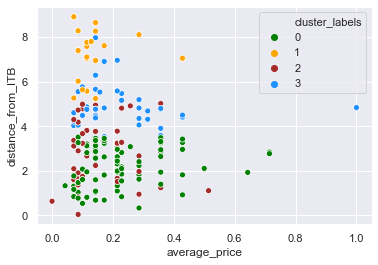

In [138]:

g =sns.scatterplot(x="average_price", y="distance_from_ITB", hue="cluster_labels",
              data=new_venue, 
                    palette=['green','orange','brown','dodgerblue'], legend='full')
plt.show()


## 5. Results and Discussion <a name="results"></a>

From the data and analysis, it shows that there are relatively a lot of restaurants and cafes nearby the campus, we got total of 210 venues that later divide to 4 clusters. Initialy, I got 229 venues data using Foursquare API, but with Zomatos API, I can filter this results to get data that match restaurants or cafe related category that I want.

The campus location is relatively near the city center, this is a factor that make the average price of further restaurant is cheaper than the one that is nearby. The data also shown us that there are a lot of 0.0 ratings at each venues. I personaly do not find that 0.0 rating is an indication that all venues of this cluster are bad, merely it caused by incomplete data that gave by the user and affect the K-Means algorithm metrics. I choose to not delete this 0.0 rating because this is useful as popularity metric. Notice that nearby restaurants tend to be have a rating than those who are further away. We can see from 4 cluster (cluster 0 - 3), that only one cluster; cluster 0 that has rating on each venue. This indicates that venues on cluster 0 is more popular than other clusters.

From each cluster we can see that every cluster has their own advantages and disadvandtages, cluster 1 and 3 by average is cheaper than 0 and 2, but those clusters is quite far from the campus. Cluster 0 and 1 have more expensive average price but those clusters are not far from the campus, moreover cluster 0 has more popular venues compare to other clusters.



## 6. Conclusion <a name="conclusion"></a>

Now it's time for me to give Budi an suggestion based on those data and analysis using K-Means clustering alghoritm. So according to the data, cluster 0 and 2 is the best for him. Cluster 2 which represent by scatters of "light green" points on the folium map has lower average price, quite near the campus, but not realy popular. Meanwhile, cluster 0 is the most popular and the nearest cluster by average ratings and distances to the campus, but also has highest average price. I personaly reccomend him cluster 0. If we see the scatter plot from "All cluster review" section  the highest average price is also caused by the numbers of venues that exist on cluster 0. Cluster 0 has the most number of venues, more than twice that cluster 2 has. Cluster 0 has a lot of venues that in same range with cluster 2 has, also a lot of venues in more expensive range. This make cluster 0 average price is more expensive from the cluster 1.

I consider this data analysis need more development, for example, the accomodation near the campus usualy has higher price than the rest, it should be a metric to consider. But, due to the limitance of getting that data, my suggestion is limited based on data from Foursquare and Zomato API.